### Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보자.

# 0. 데이터 로드

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 Userid와 시간 순서로 정렬해줍니다.

data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- **UserID가 SessionID 역할**을 해야 한다.

- **Rating 정보**가 포함되어 있다. 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 한다.

- **Time 항목**에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있다.

# Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 **항목별 기본분석, session length, session time, cleaning 등의 작업**을 진행합니다.<br>
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

- 유저가 약 6000, 아이템은 약 3000개 있다.

## SessionId 칼럼 추가
유저 아이디로 Session을 취급하면 2년이 지난 데이터도 하나의 session으로 처리하게 되므로<br>
같은 유저 아이디의 데이터를 시간을 기준으로 더 쪼갠다.

In [4]:
data['Time_diff'] = data['Time'].diff().fillna(0)
data

,UserId,ItemId,Rating,Time,Time_diff
31,1,3186,4,978300019,0.0
22,1,1270,5,978300055,36.0
27,1,1721,4,978300055,0.0
37,1,1022,5,978300055,0.0
24,1,2340,3,978300103,48.0
...,...,...,...,...,...
1000019,6040,2917,4,997454429,31.0
999988,6040,1921,4,997454464,35.0
1000172,6040,1784,3,997454464,0.0
1000167,6040,161,3,997454486,22.0


In [5]:
data[data['Time_diff']>100]

,UserId,ItemId,Rating,Time,Time_diff
3,1,3408,4,978300275,103.0
7,1,2804,5,978300719,444.0
9,1,919,4,978301368,608.0
43,1,2692,4,978301570,172.0
26,1,1097,4,978301953,176.0
...,...,...,...,...,...
999975,6040,3182,5,984195682,19366782.0
999984,6040,2575,4,997453762,13258080.0
999917,6040,3421,3,997453909,113.0
1000118,6040,457,4,997454349,137.0


UserId가 바뀌는 부분의 Time_diff는 양수가 될 수도 있지만 음수가 될 수도 있다.(정렬기준이 UserId 다음 Time이기 때문)<br>
이는 사실상 0으로 처리해줘야 하지만 크게 상관없는 것 같다.

In [6]:
data[data['Time_diff']<0]

,UserId,ItemId,Rating,Time,Time_diff
130,2,1198,4,978298124,-526227.0
217,3,593,3,978297018,-3156.0
234,4,1210,3,978293924,-4580.0
325,5,2717,1,978241072,-53210.0
461,6,3072,4,978236075,-10510.0
...,...,...,...,...,...
999375,6036,1721,4,956709349,-4291.0
999568,6037,1882,1,956708997,-46199.0
999726,6038,920,3,956706827,-95013.0
999794,6039,282,4,956705158,-12046.0


In [7]:
session_id = 1
def get_session_id(x):
    global session_id
    if x['Time_diff']>=100:    # Session을 나누는 기준 설정
        session_id += 1
    return session_id

data['SessionId'] = data.apply(get_session_id, axis=1)
data

,UserId,ItemId,Rating,Time,Time_diff,SessionId
31,1,3186,4,978300019,0.0,1
22,1,1270,5,978300055,36.0,1
27,1,1721,4,978300055,0.0,1
37,1,1022,5,978300055,0.0,1
24,1,2340,3,978300103,48.0,1
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,31.0,66272
999988,6040,1921,4,997454464,35.0,66272
1000172,6040,1784,3,997454464,0.0,66272
1000167,6040,161,3,997454486,22.0,66272


In [9]:
data['SessionId'].nunique()

66273

## 1.1 Time

In [10]:
data.dtypes

UserId         int32
ItemId         int32
Rating         int32
Time           int64
Time_diff    float64
SessionId      int64
dtype: object

In [11]:
import datetime

def to_date(x):
    date = datetime.datetime.fromtimestamp(x)
    date = date.strftime('%Y-%m-%d %H:%M:%S')
    return datetime.datetime.strptime(date,"%Y-%m-%d %H:%M:%S")    # datetime 형식으로 변환

data['Time'] = data['Time'].apply(to_date)
data['Time']

31        2000-12-31 22:00:19
22        2000-12-31 22:00:55
27        2000-12-31 22:00:55
37        2000-12-31 22:00:55
24        2000-12-31 22:01:43
                  ...        
1000019   2001-08-10 14:40:29
999988    2001-08-10 14:41:04
1000172   2001-08-10 14:41:04
1000167   2001-08-10 14:41:26
1000042   2001-08-20 13:44:15
Name: Time, Length: 1000209, dtype: datetime64[ns]

In [12]:
data

,UserId,ItemId,Rating,Time,Time_diff,SessionId
31,1,3186,4,2000-12-31 22:00:19,0.0,1
22,1,1270,5,2000-12-31 22:00:55,36.0,1
27,1,1721,4,2000-12-31 22:00:55,0.0,1
37,1,1022,5,2000-12-31 22:00:55,0.0,1
24,1,2340,3,2000-12-31 22:01:43,48.0,1
...,...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,31.0,66272
999988,6040,1921,4,2001-08-10 14:41:04,35.0,66272
1000172,6040,1784,3,2001-08-10 14:41:04,0.0,66272
1000167,6040,161,3,2001-08-10 14:41:26,22.0,66272


## 1.2 Session Length
우선 UserId를 기준으로 Session단위를 정하였다.

In [13]:
session_length = data.groupby('SessionId').size()    # 같은 SessionId를 공유하는 데이터 row의 개수
session_length

SessionId
1         6
2         1
3         5
4         2
5        10
         ..
66269     1
66270     3
66271    11
66272     7
66273     1
Length: 66273, dtype: int64

### session_length의 통계수치
- 중간값, 평균값
- 최솟값, 최댓값
- 99.9%에 있는 데이터

In [77]:
session_length.median(), session_length.mean()

(4.0, 15.092254764383686)

In [78]:
session_length.min(), session_length.max()

(1, 1193)

In [79]:
session_length.quantile(0.999)

383.4560000000056

session길이가 최대인 데이터 중 하나를 살펴보자.
- 대강 봐도 0.01초 사이에 여러번의 클릭이 있는 것으로 보인다. (비정상적이라고 판단)

In [80]:
long_session = session_length[session_length==1193].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,Time_diff,SessionId
637775,3841,1480,3,2000-08-11 11:57:39,79091.0,44453
637808,3841,969,5,2000-08-11 11:57:39,0.0,44453
638269,3841,858,5,2000-08-11 11:57:39,0.0,44453
638716,3841,2019,5,2000-08-11 11:57:39,0.0,44453
638733,3841,1221,5,2000-08-11 11:57:39,0.0,44453
...,...,...,...,...,...,...
638038,3841,3806,5,2000-08-11 14:23:11,0.0,44453
638243,3841,1379,2,2000-08-11 14:23:11,0.0,44453
638459,3841,1928,4,2000-08-11 14:23:11,0.0,44453
638710,3841,2016,3,2000-08-11 14:23:11,0.0,44453


세션길이가 400이상인 데이터는 비정상적이라고 판단하여 제거해준다.

In [14]:
len(session_length[session_length>400])

56

### session length 누적합 시각화

In [92]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.296425
2      0.420352
3      0.496567
4      0.550043
5      0.590678
         ...   
372    0.998914
375    0.998929
379    0.998944
380    0.998959
382    0.998989
Length: 349, dtype: float64

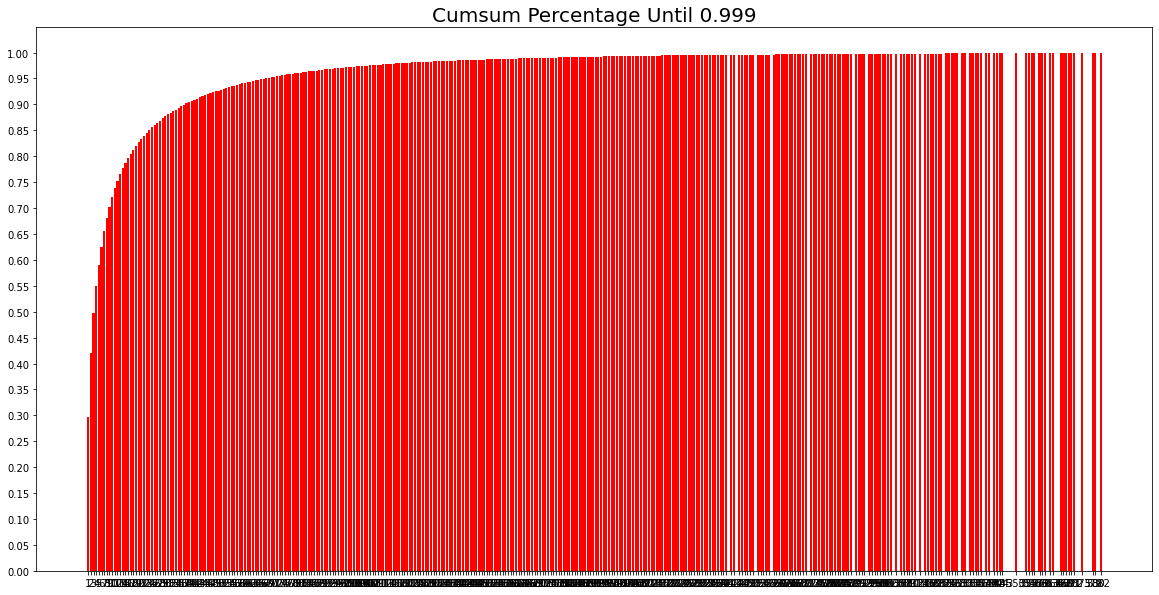

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

## 1.3 Rating
평점이 3점미만인 데이터는 제거하자.

In [15]:
data[data['Rating']<3]

,UserId,ItemId,Rating,Time,Time_diff,SessionId
67,2,1213,2,2000-12-31 21:34:18,24.0,8
151,2,1090,2,2000-12-31 21:36:20,38.0,8
174,2,1968,2,2000-12-31 21:41:21,0.0,8
83,2,902,2,2000-12-31 21:41:45,0.0,8
114,2,3699,2,2000-12-31 21:46:13,30.0,8
...,...,...,...,...,...,...
999892,6040,2402,1,2000-04-26 02:35:57,16.0,66256
999902,6040,2421,1,2000-04-26 02:36:28,31.0,66256
999963,6040,2147,2,2000-04-26 02:36:28,0.0,66256
1000164,6040,154,2,2000-05-07 16:41:18,0.0,66259


In [16]:
idx = data[data['Rating']<3].index
data.drop(idx, inplace=True)

data

,UserId,ItemId,Rating,Time,Time_diff,SessionId
31,1,3186,4,2000-12-31 22:00:19,0.0,1
22,1,1270,5,2000-12-31 22:00:55,36.0,1
27,1,1721,4,2000-12-31 22:00:55,0.0,1
37,1,1022,5,2000-12-31 22:00:55,0.0,1
24,1,2340,3,2000-12-31 22:01:43,48.0,1
...,...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,31.0,66272
999988,6040,1921,4,2001-08-10 14:41:04,35.0,66272
1000172,6040,1784,3,2001-08-10 14:41:04,0.0,66272
1000167,6040,161,3,2001-08-10 14:41:26,22.0,66272


## Data Cleansing
- 너무 짧은 세션 제거
- 너무 적게 선택된 item 제거

In [17]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [26]:
item_popular = data.groupby('ItemId').size()
item_popular[item_popular >= 20].index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            3936, 3937, 3943, 3946, 3947, 3948, 3949, 3950, 3951, 3952],
           dtype='int64', name='ItemId', length=2805)

In [27]:
data = cleanse_recursive(data, shortest=3, least_click=30)
data

,UserId,ItemId,Rating,Time,Time_diff,SessionId
31,1,3186,4,2000-12-31 22:00:19,0.0,1
22,1,1270,5,2000-12-31 22:00:55,36.0,1
27,1,1721,4,2000-12-31 22:00:55,0.0,1
37,1,1022,5,2000-12-31 22:00:55,0.0,1
24,1,2340,3,2000-12-31 22:01:43,48.0,1
...,...,...,...,...,...,...
999923,6040,232,5,2001-08-10 14:39:58,31.0,66272
1000019,6040,2917,4,2001-08-10 14:40:29,31.0,66272
999988,6040,1921,4,2001-08-10 14:41:04,35.0,66272
1000172,6040,1784,3,2001-08-10 14:41:04,0.0,66272


## 1.5 Train/ Valid/ Test split
데이터셋 분리

In [28]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [29]:
tr, test = split_by_date(data, n_days=60)
tr, val = split_by_date(tr, n_days=90)

In [32]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [33]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 779068
	 Sessions: 34422
	 Items: 2510
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-30 16:19:28

* valid Set Stats Info
	 Events: 4476
	 Sessions: 327
	 Items: 1532
	 First Time : 2000-04-27 15:17:08
	 Last Time : 2002-12-30 02:26:14

* test Set Stats Info
	 Events: 4797
	 Sessions: 311
	 Items: 1549
	 First Time : 2000-05-01 05:44:56
	 Last Time : 2003-02-28 17:49:50



기간이 뭔가 이상하게 나오는데 예제와 똑같이 했는데 왜 이렇게 되는지 모르겠다..

In [34]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

분리한 데이터셋을 저장해놓는다.

In [35]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.

In [36]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [37]:
tr_dataset = SessionDataset(tr)

tr_dataset.df

,UserId,ItemId,Rating,Time,Time_diff,SessionId,item_idx
31,1,3186,4,2000-12-31 22:00:19,0.0,1,0
22,1,1270,5,2000-12-31 22:00:55,36.0,1,1
27,1,1721,4,2000-12-31 22:00:55,0.0,1,2
37,1,1022,5,2000-12-31 22:00:55,0.0,1,3
24,1,2340,3,2000-12-31 22:01:43,48.0,1,4
...,...,...,...,...,...,...,...
999923,6040,232,5,2001-08-10 14:39:58,31.0,66272,952
1000019,6040,2917,4,2001-08-10 14:40:29,31.0,66272,1066
999988,6040,1921,4,2001-08-10 14:41:04,35.0,66272,306
1000172,6040,1784,3,2001-08-10 14:41:04,0.0,66272,84


In [38]:
tr_dataset.click_offsets

array([     0,     50,    165, ..., 778688, 778807, 779068], dtype=int32)

In [39]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6018, 6019, 6020])

In [40]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1          # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]     # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])       # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

# Step 3. 모델 구성
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

In [41]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [43]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [44]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

# 하이퍼파라미터를 가지고 있는 객체 생성
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [39]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 3696)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      562200    
_________________________________________________________________
dropout (Dropout)            (32, 50)                  0         
_________________________________________________________________
dense (Dense)                (32, 3696)                188496    
Total params: 750,696
Trainable params: 750,696
Non-trainable params: 0
_________________________________________________________________


In [48]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

# Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다.

In [41]:
train_model(model, args)

Train:   0%|          | 0/29161 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.82]

	 - Recall@20 epoch 1: 0.286342
	 - MRR@20    epoch 1: 0.080407



Train:   0%|          | 0/29161 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.69]

	 - Recall@20 epoch 2: 0.322334
	 - MRR@20    epoch 2: 0.097345



Evaluation:  89%|████████▉ | 804/903 [03:38<00:26,  3.68it/s]

	 - Recall@20 epoch 3: 0.332167
	 - MRR@20    epoch 3: 0.104171



# Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [45]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  92%|█████████▏| 900/979 [04:06<00:21,  3.66it/s]

	 - Recall@20: 0.337708
	 - MRR@20: 0.103922



# 다양한 시도

## 모델2
- 하이퍼파라미터 그대로
- Rating 작은 데이터 제거, SessionId생성기준 수정 등 데이터전처리

In [46]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.2, lr=0.001, epochs=3, k=20)
model2 = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 1, 2510)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      384300    
_________________________________________________________________
dropout_1 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (32, 2510)                128010    
Total params: 512,310
Trainable params: 512,310
Non-trainable params: 0
_________________________________________________________________


In [49]:
train_model(model2, args)

Train: 24019it [04:52, 82.07it/s, accuracy=0, train_loss=5.3]                                 
Train:   0%|          | 0/23270 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.14]

	 - Recall@20 epoch 1: 0.188578
	 - MRR@20    epoch 1: 0.048029



Train: 24019it [04:57, 80.87it/s, accuracy=0.0312, train_loss=5.07]                           
Train:   0%|          | 0/23270 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.46]

	 - Recall@20 epoch 2: 0.216236
	 - MRR@20    epoch 2: 0.056244



Train: 24019it [04:40, 85.57it/s, accuracy=0.0625, train_loss=4.83]                           
Evaluation:  67%|██████▋   | 87/129 [00:17<00:08,  4.84it/s]

	 - Recall@20 epoch 3: 0.220187
	 - MRR@20    epoch 3: 0.059135



데이터 전처리로 불필요한 데이터를 제거하니 학습시간이 훨씬 감소했다.

In [51]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model2, args, test)

Evaluation:  59%|█████▉    | 83/140 [00:16<00:11,  4.91it/s]

	 - Recall@20: 0.280120
	 - MRR@20: 0.080248



Recall이 첫번째 모델에 비해 감소했다. 데이터가 줄어서일까? 아니면 drop_rate를 늘려서 일까?

## 모델3
- 모델2와 같은 데이터 전처리
- 하이퍼파라미터 조정 (epochs, batch_size, k)

In [52]:
args1 = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=30)
model3 = create_model(args1)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(16, 1, 2510)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      384300    
_________________________________________________________________
dropout_2 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (16, 2510)                128010    
Total params: 512,310
Trainable params: 512,310
Non-trainable params: 0
_________________________________________________________________


In [53]:
train_model(model3, args1)

Train: 48173it [08:00, 100.34it/s, accuracy=0, train_loss=5.4]                                 
Train:   0%|          | 0/46540 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.86] 

	 - Recall@30 epoch 1: 0.272148
	 - MRR@30    epoch 1: 0.058257



Train: 48173it [08:03, 99.71it/s, accuracy=0, train_loss=5.18]                                 
Train:   0%|          | 0/46540 [00:00<?, ?it/s, accuracy=0.188, train_loss=4.77] 

	 - Recall@30 epoch 2: 0.283677
	 - MRR@30    epoch 2: 0.063927



Train: 48173it [07:59, 100.43it/s, accuracy=0, train_loss=5.08]                                
Train:   0%|          | 0/46540 [00:00<?, ?it/s, accuracy=0, train_loss=5.33]     

	 - Recall@30 epoch 3: 0.284587
	 - MRR@30    epoch 3: 0.064122



Train: 48173it [08:02, 99.76it/s, accuracy=0, train_loss=5.25]                                 
Train:   0%|          | 0/46540 [00:00<?, ?it/s, accuracy=0.188, train_loss=5.07] 

	 - Recall@30 epoch 4: 0.287318
	 - MRR@30    epoch 4: 0.065716



Train: 48173it [08:13, 97.55it/s, accuracy=0.0625, train_loss=5.11]                            
Evaluation:  80%|███████▉  | 206/259 [00:31<00:08,  6.44it/s]

	 - Recall@30 epoch 5: 0.291566
	 - MRR@30    epoch 5: 0.066267



In [54]:
test_model(model3, args1, test)

Evaluation:  82%|████████▏ | 230/280 [00:27<00:05,  8.47it/s]

	 - Recall@30: 0.280978
	 - MRR@30: 0.081966



학습시간은 너무 오래걸리긴 하지만 epoch은 크게 하는 게 더 효과적인 것 같다.<br>
근데 모델3 역시 첫번째 모델에서 거의 모든 데이터로 학습시키긴 것보다 Recall이 낮다.

# 루브릭

1.Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
- 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.

2.RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.
- 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.

3.세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.
3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

# 회고

SessionId를 지정하는 것이 제일 어려웠다. UTC Time을 datetime형식으로 먼저 변환한 후에 timedelata로 시간의 차이를 구해서 SessionId를 하나씩 더해가는 식으로 구현하려 했으나 해내지 못했다. UserId를 그대로 세션으로 사용하는 것은 몇년간의 데이터를 그대로 뭉뚱그려서 하나의 세션으로 보는 것이기 때문에 UserId를 사용하면 제대로 된 학습이 되지 않을 것이라고 생각했다. 결국 또 형준님의 도움을 받아 SessionId를 UTC Time으로도 구할 수 있다는 인사이트를 얻어서  SessionId칼럼을 생성하는 데 성공했다.

<br>

중간에 train, test, val 데이터셋을 분리한 후에 확인했을 때 원래는 기간이 딱 분리가 되는게 맞는 것 같은데 뭔가 이상하다. 정렬을 잘못한 탓인지 뭐때문인지 정확이 모르겠다. 근데 그 뒤의 코드들은 문제없이 돌아가는게 학습에 큰 영향이 있는 것 같기도, 중요한 것 같기도.. 긴가민가하다.

<br>

데이터프레임을 원하는 대로 다루기 위해서는 확실히 다양한 데이터셋을 많이 다뤄보는게 중요한 것 같다. 이번에 DataFrame.Diff메소드를 바로 떠올려서 사용하지 못한게 좀 아쉽다.

<br>

RNN은 학습시간이 무시못할정도로 매우 오래걸린다. 지금까지 한 프로젝트 중에 처음으로 어떻게 하면 학습시간을 줄일 수 있을까 궁금해졌다. 그래도 데이터 전처리를 좀더 한 후에 학습하니 학습시간이 많이 줄었다.